In [4]:
import smtpd
import warnings
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
import scipy.stats.morestats
import matplotlib
from scipy.ndimage import gaussian_filter
from rsa_utils import *
import seaborn as sns
from metrics import *
from cebra_utils import *
from riab_utils import *
from dat import *
%matplotlib inline

In [5]:
sns.set(style='dark', font_scale=1.25)
p = r'/Users/jquinnlee/Desktop/georep_hipp'
os.chdir(p)

In [6]:
animals = ['QLAK-CA1-08', 'QLAK-CA1-30', 'QLAK-CA1-50', 'QLAK-CA1-51', 'QLAK-CA1-56', 'QLAK-CA1-74', 'QLAK-CA1-75']
animal = animals[2]

In [7]:
dat = load_dat(animal, os.path.join(p, "data"))

Loading preprocessed data for animal QLAK-CA1-50


In [13]:
rsm_parts_animals = joblib.load(os.path.join(p, "results", "rsm_parts_animals"))
rsm_parts_ordered = joblib.load(os.path.join(p, "results", 'rsm_parts_ordered'))
rsm_parts_averaged = joblib.load(os.path.join(p, "results", 'rsm_parts_averaged'))
behav_dict = joblib.load(os.path.join(p, "data", "behav_dict"))
envs = behav_dict[animals[0]]["envs"][:11]

In [8]:
# represent every partition in the environment with a one in the two-dim matrix
from scipy.spatial.distance import euclidean
euc_parts = []
for e, env in enumerate(envs):
    env_mat = get_env_mat(env)
    # have to first orient the env mat the same as the rate maps to get the right order of comparisons
    flat_env_mat = np.flipud(env_mat).T.ravel()
    for n, part in enumerate(flat_env_mat):
        this_part = np.zeros(flat_env_mat.shape[0])
        if part:
            this_part[n] = 1.
        else:
            this_part *= np.nan
        euc_parts.append(this_part.reshape(env_mat.shape[0], -1))

euc_similarity = np.zeros([len(envs) * flat_env_mat.shape[0],
                           len(envs) * flat_env_mat.shape[0]]) * np.nan
for i, part1 in enumerate(euc_parts):
    for j, part2 in enumerate(euc_parts):
        if np.all(~np.isnan(part1)) and np.all(~np.isnan(part2)):
            euc_similarity[i, j] = np.linalg.norm(np.abs(np.argwhere(part1) -
                                                         np.argwhere(part2)))
euc_similarity = np.nanmax(euc_similarity) - euc_similarity
euc_similarity -= np.nanmin(euc_similarity)
euc_similarity /= np.nanmax(euc_similarity)

In [9]:

# represent every partition in the environment with its boundary conditions (1 or 0)
from scipy.spatial.distance import hamming
boundary_conditions = {"envs": envs, "bounds": []}
for env in envs:
    env_mat = np.flipud(get_env_mat(env)).T
    env_mat = ~np.pad(env_mat, 1, "constant").astype(bool)
    part_boundaries = np.zeros([3, 3, 4])
    for row in np.arange(1, 4):
        for col in np.arange(1, 4):
            if ~env_mat[row, col]:
                north = env_mat[row + 1, col] # N boundary condition
                west = env_mat[row, col - 1] # W boundary condition
                south = env_mat[row - 1, col]
                east = env_mat[row, col + 1]
                part_boundaries[row-1, col-1, :] = np.array([north, west, south, east])
            else:
                part_boundaries[row - 1, col - 1, :] = np.zeros(4) * np.nan
    boundary_conditions["bounds"].append([part_boundaries.reshape(-1, 4)])
boundary_conditions["bounds"] = np.array(boundary_conditions["bounds"]).reshape(-1, 4)

bound_similarity = np.zeros([len(envs) * flat_env_mat.shape[0],
                             len(envs) * flat_env_mat.shape[0]]) * np.nan
for i, bound1 in enumerate(boundary_conditions["bounds"]):
    for j, bound2 in enumerate(boundary_conditions["bounds"]):
        if np.all(~np.isnan(bound1)) and np.all(~np.isnan(bound2)):
            bound_similarity[i, j] = 1 - hamming(bound1, bound2)
        else:
            bound_similarity[i, j] = np.nan

In [10]:

# first build out transition matrices for each animal
transition_matrices = {}
n_bins = 15
step_size = 30 # preliminary analysis showed that step size at 1 frame does not fit nearly as well as 1 or 2 sec (30-60 frames)

for animal in animals:
    dat = load_dat(animal, os.path.join(p, "data"))
    transition_matrices[animal] = {"T": get_transition_matrix(dat[animal]["position"].T,
                                                              dat[animal]["maps"]["smoothed"],
                                                              n_bins = 15,
                                                              step_size=step_size)[0],
                                   "envs": dat[animal]["envs"]}
    del dat
# re-order the transition matrices to follow cannon order (first animal), and break up by sequence
for animal in animals:
    transition_matrices[animal]["T_shapes"] = np.zeros([envs.shape[0], n_bins**2, n_bins**2])
    for e, env in enumerate(envs):
        # pull out transition matrices for each shape following cannon order, and average across sequences
        env_idx = np.where(transition_matrices[animal]["envs"] == env)[0]
        transition_matrices[animal]["T_shapes"][e] = np.nanmean(transition_matrices[animal]["T"][:, :, env_idx], -1)
# average across animals
T_shapes = np.zeros([len(animals), len(envs), n_bins**2, n_bins**2])
for a, animal in enumerate(animals):
    for e, env in enumerate(envs):
        T_shapes[a, e] = transition_matrices[animal]["T_shapes"][e]
T_shapes = np.nanmean(T_shapes, axis=0).squeeze()

# in the final step of formatting the transition matrix, we need to organize it by partition
part_labels = np.flipud(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]).T) # reordered to match rate map orientation
pixel_labels = part_labels[:, :, np.newaxis].repeat(25, axis=2).reshape(3, 3, 5, 5).transpose(0, 2, 1, 3).reshape(15,
                                                                                                            15).ravel()

# now we have labels for the pixels, let's walk through each shape, and pull out the target partition
transition_parts = []
for T_shape in T_shapes:
    for part in part_labels.ravel():
        temp = deepcopy(T_shape)
        vals = temp[pixel_labels == part, pixel_labels == part]
        transition_parts.append(vals)


transition_similarity = np.zeros([99, 99]) * np.nan
for i, p1 in enumerate(transition_parts):
    for j, p2 in enumerate(transition_parts):
        transition_similarity[i, j] = pearsonr(p1, p2)[0]

Loading preprocessed data for animal QLAK-CA1-08


Calculating transition matrices across 31 days: 100%|██████████| 31/31 [00:00<00:00, 46.55it/s]


Loading preprocessed data for animal QLAK-CA1-30


Calculating transition matrices across 31 days: 100%|██████████| 31/31 [00:00<00:00, 50.46it/s]


Loading preprocessed data for animal QLAK-CA1-50


Calculating transition matrices across 31 days: 100%|██████████| 31/31 [00:00<00:00, 50.10it/s]


Loading preprocessed data for animal QLAK-CA1-51


Calculating transition matrices across 21 days: 100%|██████████| 21/21 [00:00<00:00, 51.16it/s]


Loading preprocessed data for animal QLAK-CA1-56


Calculating transition matrices across 31 days: 100%|██████████| 31/31 [00:00<00:00, 45.72it/s]


Loading preprocessed data for animal QLAK-CA1-74


Calculating transition matrices across 31 days: 100%|██████████| 31/31 [00:00<00:00, 45.31it/s]


Loading preprocessed data for animal QLAK-CA1-75


Calculating transition matrices across 31 days: 100%|██████████| 31/31 [00:00<00:00, 50.38it/s]


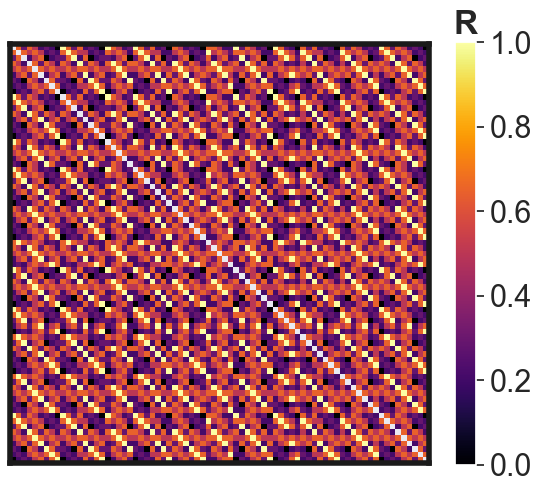

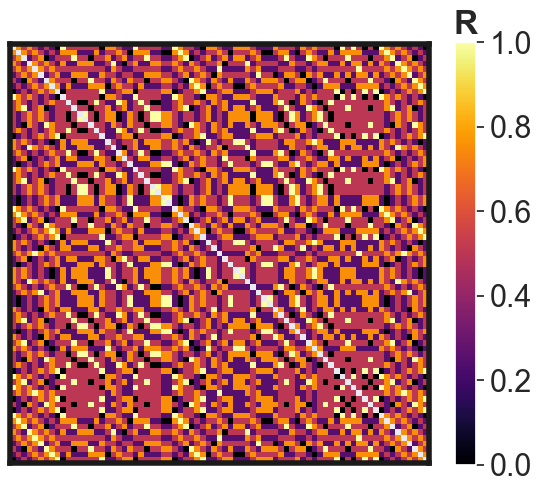

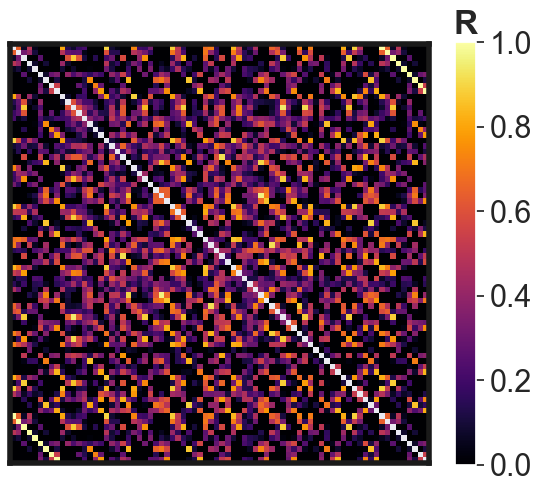

In [11]:

fig = plot_rsm_parts_averaged(euc_similarity, vmin=0, vmax=1.)

fig = plot_rsm_parts_averaged(bound_similarity, vmin=0, vmax=1.)

fig = plot_rsm_parts_averaged(transition_similarity, vmin=0., vmax=1.)

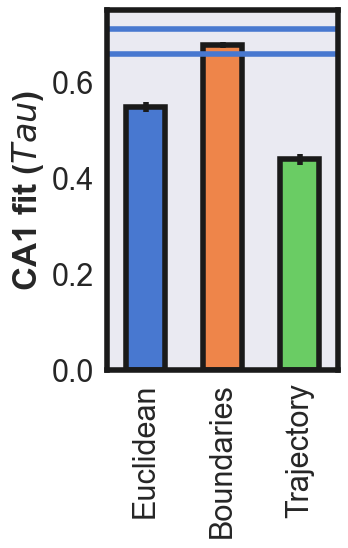

In [14]:

# calculate similarity between euc similarity, local boundary similarity, and actual data
mask = ~np.isnan(rsm_parts_averaged).astype(bool)
mask[np.tri(mask.shape[0], k=0).astype(bool)] = False

noise_margin_agg, rsm_mask_agg = get_noise_margin(rsm_parts_ordered)
# get bootstrap fits for each heuristic model
euc_fit, euc_se, euc_p_val = get_rsm_fit_bootstrap(rsm_parts_averaged,
                                                   euc_similarity,
                                                   method='Tau')
bound_fit, bound_se, bound_p_val = get_rsm_fit_bootstrap(rsm_parts_averaged,
                                                   bound_similarity,
                                                   method='Tau')
traj_fit, traj_se, traj_p_val = get_rsm_fit_bootstrap(rsm_parts_averaged,
                                                   transition_similarity,
                                                   method='Tau')


fig = plt.figure(figsize=(4, 6))
sns.set(palette="muted", style="dark", font_scale=2.)
ax = plt.subplot()
ax.bar(x=0, height=euc_fit, linewidth=4., edgecolor="k", width=0.5)
ax.errorbar(x=0, y=euc_fit, yerr=euc_se, linewidth=4., color="k")
ax.bar(x=1, height=bound_fit, linewidth=4., edgecolor="k", width=0.5)
ax.errorbar(x=1, y=bound_fit, yerr=bound_se, linewidth=4., color="k")
ax.bar(x=2, height=traj_fit, linewidth=4., edgecolor="k", width=0.5)
ax.errorbar(x=2, y=traj_fit, yerr=traj_se, linewidth=4., color="k")
ax.axhline(noise_margin_agg.mean(0)[0], color="b", linewidth=4.)
ax.axhline(noise_margin_agg.mean(0)[1], color="b", linewidth=4.)
plt.setp(ax.spines.values(),linewidth=4., color="k")
ax.set_xlim(-.5, 2.5)
ax.set_ylim(0., 0.75)
ax.set_ylabel("CA1 fit ($Tau$)", weight="bold")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["Euclidean", "Boundaries", "Trajectory"], rotation=90)
plt.tight_layout()
plt.show()